In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!pip install pytorch-lightning torchbench

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.9/776.9 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.0/74.0 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 39.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.0/58.0 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.6/58.6 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.0/128.0 kB 18.4 MB/s eta 0:00:00
  Created wheel for tabulate: filename=tabulate-0.8.3-py3-none-any.whl size=23374 sha256=a3a81f74d082e92875b1d53d2ef727b00ad1013357bee6698a66173c1b1d75e7
  Stored in directory: /root/.cache/pip/wheels/ea/f4/08/6ac7d5e3a397d0e

In [3]:
!pip install pytorch-lightning pycocotools

In [4]:
# !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth

In [5]:
!pip install safetensors

In [6]:
!unzip ComputerVision_Semantic_Segmentation.zip

Archive:  sam_lora_ade.zip
   creating: ComputerVision_Semantic_Segmentation/
  inflating: ComputerVision_Semantic_Segmentation/lora_ade.ipynb  
  inflating: ComputerVision_Semantic_Segmentation/main.py  
  inflating: ComputerVision_Semantic_Segmentation/model_2.py  
  inflating: ComputerVision_Semantic_Segmentation/sam_lora.py  
  inflating: ComputerVision_Semantic_Segmentation/segformer_sam.ipynb  
  inflating: ComputerVision_Semantic_Segmentation/train.py  
  inflating: ComputerVision_Semantic_Segmentation/train_2.py  
  inflating: ComputerVision_Semantic_Segmentation/utils.py  
  inflating: ComputerVision_Semantic_Segmentation/utils_2.py  
  inflating: ComputerVision_Semantic_Segmentation/viz.py  
  inflating: ComputerVision_Semantic_Segmentation/.gitignore  
   creating: ComputerVision_Semantic_Segmentation/.git/
  inflating: ComputerVision_Semantic_Segmentation/.git/description  
  inflating: ComputerVision_Semantic_Segmentation/.git/config  
  inflating: ComputerVision_Semantic_

In [2]:
%cd ComputerVision_Semantic_Segmentation

/content/ComputerVision_Semantic_Segmentation


In [10]:
!pip install -e ./segment-anything-main/

Obtaining file:///content/ComputerVision_Semantic_Segmentation/segment-anything-main
  Preparing metadata (setup.py) ... done
  Running setup.py develop for segment-anything


In [2]:
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth

--2023-12-01 04:16:28--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 52.84.251.106, 52.84.251.27, 52.84.251.15, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|52.84.251.106|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 375042383 (358M) [binary/octet-stream]
Saving to: ‘sam_vit_b_01ec64.pth’

sam_vit_b_01ec64.pt 100%[===================>] 357.67M   170MB/s    in 2.1s    

2023-12-01 04:16:30 (170 MB/s) - ‘sam_vit_b_01ec64.pth’ saved [375042383/375042383]



In [3]:
from utils import *
from sam_lora import *



sam = sam_model_registry["vit_b"](checkpoint="sam_vit_b_01ec64.pth")
lora_sam = LoRA_Sam(sam,r = 4)

In [4]:
import torch
from torch import nn
import numpy as np
import pytorch_lightning as pl
from torchbench.datasets import ADE20K
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_tensor, pil_to_tensor, resize, normalize
from torchvision.transforms import InterpolationMode
from torch.utils.data import Subset, DataLoader
from tqdm import tqdm

In [5]:
def simple_ade20k_transforms(image, target):
    image = resize(to_tensor(image), (256, 256))
    image = normalize(image, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    target = resize(pil_to_tensor(target), (64, 64), InterpolationMode.NEAREST)[0].long()
    # 0: background, -1: plant, -2: person/animal, -3: vehicle
    class_mapping = [(5, -1), (10, -1), (13, -2), (18, -1), (21, -3), (67, -1),
                     (77, -3), (84, -3), (91, -3), (103, -3), (104, -3), (127, -2), (128, -3)]
    for cm in class_mapping:
        target[target == cm[0]] = cm[1]
    target[target > 0] = 0
    target *= -1
    return image, target

In [6]:
train_dataset = ADE20K('data', 'train', download=True, transforms=simple_ade20k_transforms)
val_dataset = ADE20K('data', 'val', transforms=simple_ade20k_transforms)

967385088it [03:13, 4997821.15it/s]                               


Extracting data/ADEChallengeData2016.zip to data


In [7]:
train_loader = DataLoader(train_dataset, batch_size=16)
val_loader = DataLoader(val_dataset, batch_size=16)

In [8]:
def trim_dataset(dataset):
    valid_indices = []
    for entry in tqdm(range(len(dataset))):
        _, target = dataset[entry]
        if (target > 0).float().mean() > 0.01:
            valid_indices.append(entry)
    if len(dataset) > len(valid_indices):
        dataset = Subset(dataset, valid_indices)
    return dataset

train_dataset = trim_dataset(train_dataset)
val_dataset = trim_dataset(val_dataset)

  0%|          | 0/20210 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 2000/2000 [00:09<00:00, 212.19it/s]


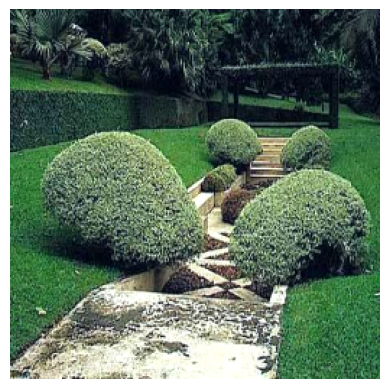

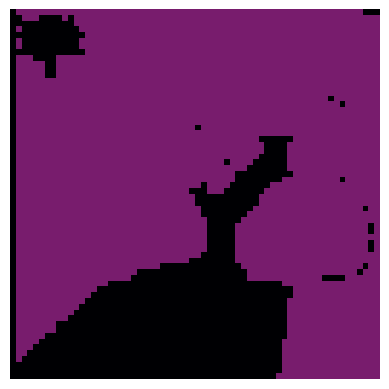

In [9]:
idx = 600
plt.imshow(train_dataset[idx][0].permute(1, 2, 0) / 4 + 0.5) # just for visualization
plt.axis('off')
plt.show()
plt.imshow(train_dataset[idx][1], vmin=0, vmax=3, cmap='inferno')
plt.axis('off')
plt.show()

In [10]:
train_dataset[idx][0].shape

torch.Size([3, 256, 256])

In [11]:
from torch.utils.data import Subset
indices = range(50)
subset_dataset = Subset(train_dataset, indices)

In [12]:
num_epochs = 10
device = 'cuda'
optimizer = torch.optim.Adam(lora_sam.sam.parameters(), lr=1e-5)
lora_sam.sam.to(device)
criteria = nn.CrossEntropyLoss()

for epoch in range(num_epochs):
  running_loss = 0.0
  running_cate_loss = 0.0
  running_mask_loss = 0.0
  running_iou_loss = 0.0

  pbar = tqdm(subset_dataset, desc=f"Epoch [{epoch + 1}/{num_epochs}]")

  count = 0

  for image0, targets in pbar:
    count += 1
    optimizer.zero_grad()

    image = F.interpolate(image0[None, :], size=(1024, 1024), mode='bilinear')
    image = image.to(device)

    target = targets[None, :]  # TODO: batch
    target_tensor = target.clone()
    batch_size, height, width = target_tensor.shape
    # one_hot_target = torch.zeros(batch_size, 4, height, width).to(target_tensor.device)
    # one_hot_target.scatter_(1, target_tensor.unsqueeze(1), 1)
    # selected_target = one_hot_target
    # selected_target = selected_target[0, 0]
    selected_target = target_tensor

    selected_target = selected_target.to(device)

    features = lora_sam.sam.image_encoder(image)

    sparse_embeddings, dense_embeddings = lora_sam.sam.prompt_encoder(
                points=None,
                boxes=None,
                masks=None,
                )

    image_pe_scaled = lora_sam.sam.prompt_encoder.get_dense_pe()

    # dense_embeddings = F.interpolate(dense_embeddings, size=(dense_embeddings.shape[-2]//4, dense_embeddings.shape[-1]//4), mode='bilinear', align_corners=False)
    # image_pe_orig = lora_sam.sam.prompt_encoder.get_dense_pe()
    # image_pe_scaled = F.interpolate(image_pe_orig, size=(image_pe_orig.shape[-2]//4, image_pe_orig.shape[-1]//4), mode='bilinear', align_corners=False)

    low_res_masks, iou_predictions = lora_sam.sam.mask_decoder(
                image_embeddings=features,
                image_pe=image_pe_scaled,
                sparse_prompt_embeddings=sparse_embeddings,
                dense_prompt_embeddings=dense_embeddings,
                # multimask_output=False,
                multimask_output=True
            )

    # print('selected_target: ', selected_target.shape)
    selected_target = selected_target.float()
    # selected_target = F.interpolate(selected_target[None, :], size=(256, 256), mode='bilinear')
    selected_target = F.interpolate(selected_target.unsqueeze(0), scale_factor=4, mode='nearest')
    # print('selected_target: ', selected_target.shape)
    # print('selected_target: ', selected_target)
    # print('low_res_masks: ', low_res_masks.shape)
    selected_target = selected_target.long()
    selected_target = selected_target.to(device)

    # if count > 10:
    #   break

    # # focal_loss = mask_focal_loss(low_res_masks, selected_target)
    # dice_loss = mask_dice_loss(low_res_masks, selected_target)
    # iou_loss = iou_token_loss(iou_predictions, low_res_masks, selected_target)

    # # loss = focal_loss + dice_loss + iou_loss
    # loss = dice_loss + iou_loss

    low_res_masks = low_res_masks.permute(0, 2, 3, 1).reshape(-1, 4)
    selected_target = selected_target.reshape(-1)
    loss = criteria(low_res_masks, selected_target)
    # loss = mask_dice_loss(low_res_masks, selected_target)

    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    # running_cate_loss += focal_loss.item()
    # running_mask_loss += dice_loss.item()
    # running_iou_loss += iou_loss.item()

    # pbar.set_postfix({
    #           'Total Loss': f"{running_loss / (pbar.n + 1):.4e}",
    #           'Cate Loss': f"{running_cate_loss / (pbar.n + 1):.4e}",
    #           'Mask Loss': f"{running_mask_loss / (pbar.n + 1):.4e}",
    #           'IoU Loss': f"{running_iou_loss / (pbar.n + 1):.4e}"
    #       })

    pbar.set_postfix({
              'Total Loss': f"{running_loss / (pbar.n + 1):.4e}"
          })



Epoch [3/10]:  96%|█████████▌| 48/50 [00:12<00:00,  3.70it/s, Total Loss=4.0412e-01]


KeyboardInterrupt: ignored

In [13]:
idx_ = 6

image0 = subset_dataset[idx_][0]
targets = subset_dataset[idx_][1]

In [14]:
# np.save('img_2.npy', image0)

# image0 = np.load('orig_img.npy')
# image0 = torch.tensor(image0)

In [15]:
select_channel = 0

In [16]:
lora_sam.sam.to(device)


image = F.interpolate(image0[None, :], size=(1024, 1024), mode='bilinear')
image = image.to(device)

target = targets[None, :]  # TODO: batch
target_tensor = target.clone()
batch_size, height, width = target_tensor.shape
one_hot_target = torch.zeros(batch_size, 4, height, width).to(target_tensor.device)
one_hot_target.scatter_(1, target_tensor.unsqueeze(1), 1)
selected_target = one_hot_target
# selected_target = selected_target[0, select_channel]
selected_target = selected_target[0]

selected_target = selected_target.to(device)

features = lora_sam.sam.image_encoder(image)

sparse_embeddings, dense_embeddings = lora_sam.sam.prompt_encoder(
            points=None,
            boxes=None,
            masks=None,
            )

image_pe_scaled = lora_sam.sam.prompt_encoder.get_dense_pe()

# dense_embeddings = F.interpolate(dense_embeddings, size=(dense_embeddings.shape[-2]//4, dense_embeddings.shape[-1]//4), mode='bilinear', align_corners=False)
# image_pe_orig = lora_sam.sam.prompt_encoder.get_dense_pe()
# image_pe_scaled = F.interpolate(image_pe_orig, size=(image_pe_orig.shape[-2]//4, image_pe_orig.shape[-1]//4), mode='bilinear', align_corners=False)

low_res_masks, iou_predictions = lora_sam.sam.mask_decoder(
            image_embeddings=features,
            image_pe=image_pe_scaled,
            sparse_prompt_embeddings=sparse_embeddings,
            dense_prompt_embeddings=dense_embeddings,
            multimask_output=True,
        )

In [17]:
low_res_masks.shape

torch.Size([1, 4, 256, 256])

In [18]:
low_res_masks.shape
# mask_plot = low_res_masks[0, select_channel].cpu().detach().numpy()
mask_plot = low_res_masks[0].cpu().detach().numpy()
mask_gt_plot = selected_target.cpu().detach().numpy()
image_plot = image0.permute(1, 2, 0).cpu().detach().numpy()

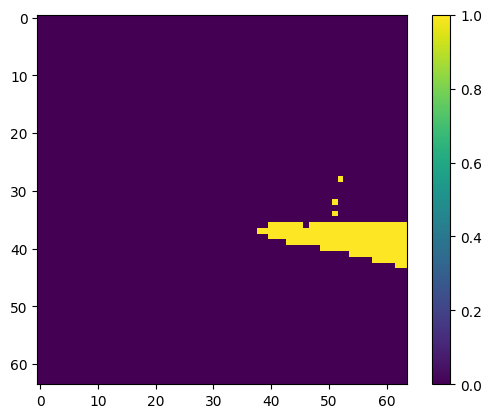

In [19]:
mask_gt_plot = np.argmax(mask_gt_plot, axis=0)

img = plt.imshow(mask_gt_plot)
plt.colorbar(img)
plt.show()

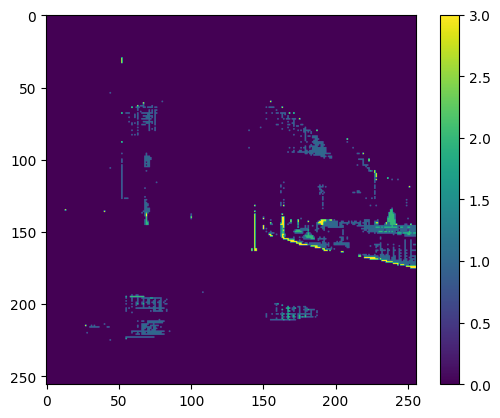

In [20]:
mask_plot = np.argmax(mask_plot, axis=0)

img = plt.imshow(mask_plot)
plt.colorbar(img)
plt.show()

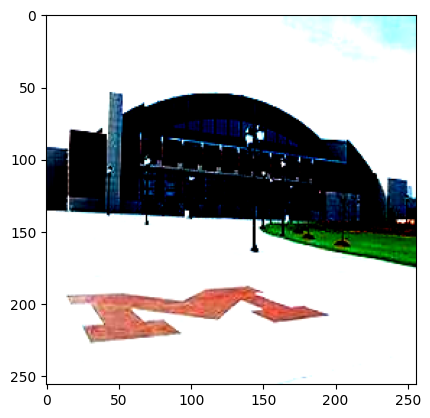

In [21]:
plt.imshow(image_plot)
plt.show()

In [22]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 57.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.8-py3-none-any.whl size=38243 sha256=763fa52deaa0320582602b8cac02572398e4e8730eb59c9dc7d00a444174e5b5
  Stored in directory: /root/.cache/pip/wheels/f8/04/36/94ff3c8a4215826a21946b34c01180817e606989fdf53f7cd6
Successfully built grad-cam


In [23]:
sam_2 = sam_model_registry["vit_b"](checkpoint="sam_vit_b_01ec64.pth")
lora_sam_2 = LoRA_Sam(sam_2,r = 4)

lora_sam_2.sam.to(device)
print(1)

1


In [24]:
# idx_ = 20

image0 = subset_dataset[idx_][0]
targets = subset_dataset[idx_][1]



image = F.interpolate(image0[None, :], size=(1024, 1024), mode='bilinear')
image = image.to(device)

target = targets[None, :]  # TODO: batch
target_tensor = target.clone()
batch_size, height, width = target_tensor.shape
one_hot_target = torch.zeros(batch_size, 4, height, width).to(target_tensor.device)
one_hot_target.scatter_(1, target_tensor.unsqueeze(1), 1)
selected_target = one_hot_target
selected_target = selected_target[0, 0]

selected_target = selected_target.to(device)

features = lora_sam_2.sam.image_encoder(image)

sparse_embeddings, dense_embeddings = lora_sam_2.sam.prompt_encoder(
            points=None,
            boxes=None,
            masks=None,
            )

image_pe_scaled = lora_sam_2.sam.prompt_encoder.get_dense_pe()

# dense_embeddings = F.interpolate(dense_embeddings, size=(dense_embeddings.shape[-2]//4, dense_embeddings.shape[-1]//4), mode='bilinear', align_corners=False)
# image_pe_orig = lora_sam_2.sam.prompt_encoder.get_dense_pe()
# image_pe_scaled = F.interpolate(image_pe_orig, size=(image_pe_orig.shape[-2]//4, image_pe_orig.shape[-1]//4), mode='bilinear', align_corners=False)

low_res_masks, iou_predictions = lora_sam_2.sam.mask_decoder(
            image_embeddings=features,
            image_pe=image_pe_scaled,
            sparse_prompt_embeddings=sparse_embeddings,
            dense_prompt_embeddings=dense_embeddings,
            multimask_output=False,
        )

In [25]:
# idx_ = 20

image0 = subset_dataset[idx_][0]
targets = subset_dataset[idx_][1]



image = F.interpolate(image0[None, :], size=(1024, 1024), mode='bilinear')
image = image.to(device)

target = targets[None, :]  # TODO: batch
target_tensor = target.clone()
batch_size, height, width = target_tensor.shape
one_hot_target = torch.zeros(batch_size, 4, height, width).to(target_tensor.device)
one_hot_target.scatter_(1, target_tensor.unsqueeze(1), 1)
selected_target = one_hot_target
selected_target = selected_target[0, 0]

selected_target = selected_target.to(device)

features = lora_sam_2.sam.image_encoder(image)

# sparse_embeddings, dense_embeddings = lora_sam_2.sam.prompt_encoder(
#             points=None,
#             boxes=None,
#             masks=None,
#             )


point_coords_ = np.array([[100, 128]])
point_coords = point_coords_ * 4
point_labels = np.array([1])
coords_torch = torch.as_tensor(point_coords, dtype=torch.float, device=device)
labels_torch = torch.as_tensor(point_labels, dtype=torch.int, device=device)
coords_torch, labels_torch = coords_torch[None, :, :], labels_torch[None, :]
points = (coords_torch, labels_torch)

sparse_embeddings, dense_embeddings = lora_sam_2.sam.prompt_encoder(
            points=points,
            boxes=None,
            masks=None,
            )


image_pe_scaled = lora_sam_2.sam.prompt_encoder.get_dense_pe()

# dense_embeddings = F.interpolate(dense_embeddings, size=(dense_embeddings.shape[-2]//4, dense_embeddings.shape[-1]//4), mode='bilinear', align_corners=False)
# image_pe_orig = lora_sam_2.sam.prompt_encoder.get_dense_pe()
# image_pe_scaled = F.interpolate(image_pe_orig, size=(image_pe_orig.shape[-2]//4, image_pe_orig.shape[-1]//4), mode='bilinear', align_corners=False)

low_res_masks, iou_predictions = lora_sam_2.sam.mask_decoder(
            image_embeddings=features,
            image_pe=image_pe_scaled,
            sparse_prompt_embeddings=sparse_embeddings,
            dense_prompt_embeddings=dense_embeddings,
            multimask_output=True,
        )

In [36]:
low_res_masks.shape
mask_index = 0
mask_plot = low_res_masks[0, mask_index].cpu().detach().numpy()
mask_gt_plot = selected_target.cpu().detach().numpy()
image_plot = image0.permute(1, 2, 0).cpu().detach().numpy()

In [37]:
low_res_masks.shape

torch.Size([1, 4, 256, 256])

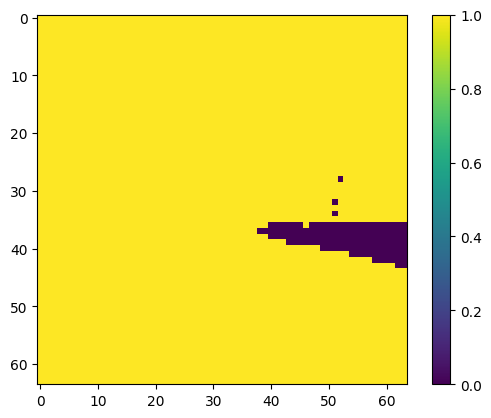

In [38]:
img = plt.imshow(mask_gt_plot)
plt.colorbar(img)
plt.show()

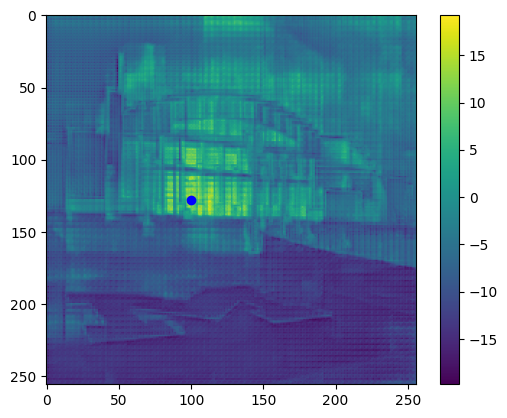

In [39]:
img = plt.imshow(mask_plot)
plt.colorbar(img)


plt.scatter(point_coords_[0, 0], point_coords_[0, 1], color='blue', marker='o')

plt.show()

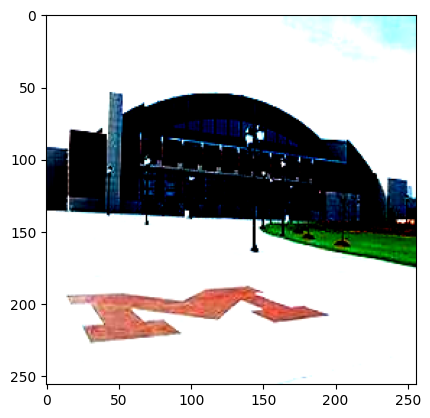

In [40]:
plt.imshow(image_plot)
plt.show()

In [31]:
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.6 MB/s eta 0:00:00


In [57]:
from model_2 import *
from train_2 import *

model = SegFormer_B0()

model.load_state_dict(torch.load('../model.pth'))
model.to(device)
print(1)

1


In [58]:


image0 = np.load('../img_3.npy')
image0 = torch.tensor(image0)

(64, 64)


NameError: ignored

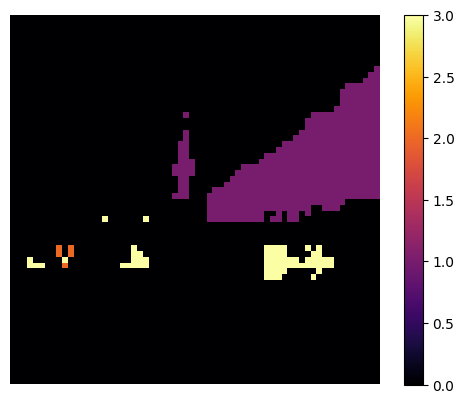

In [68]:
test = model(image0[None, :].to(device))
test = test[0].detach().cpu().numpy()
test = np.argmax(test, axis=0)
print(test.shape)

threshold = 2

# test = np.where(test > threshold, 1, 0)


img = plt.imshow(test, vmin=0, vmax=3, cmap='inferno')
plt.colorbar(img)
plt.axis('off')
# plt.savefig('result_'+str(idx)+ '_c_' + str(test_channel)+'.jpg')
# plt.savefig('result_raw_'+str(idx)+ '_c_' + str(test_channel)+'.jpg')
plt.scatter(point_coords_[0, 0]/4, point_coords_[0, 1]/4, color='blue', marker='o')
plt.show()

NameError: ignored

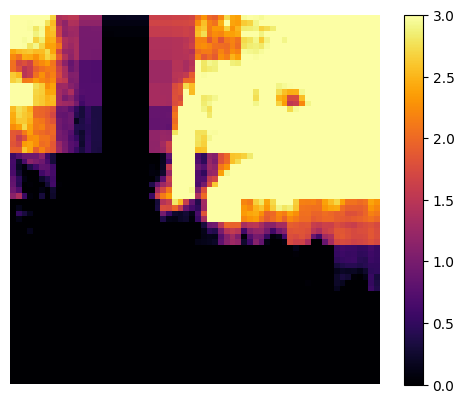

In [60]:
test_channel = 1

test = model(image0[None, :].to(device))
# test = model(train_dataset[idx][0][None, :].to(device))
test = test[0,test_channel].detach().cpu().numpy()

threshold = 2

# test = np.where(test > threshold, 1, 0)


img = plt.imshow(test, vmin=0, vmax=3, cmap='inferno')
plt.colorbar(img)
plt.axis('off')
# plt.savefig('result_'+str(idx)+ '_c_' + str(test_channel)+'.jpg')
# plt.savefig('result_raw_'+str(idx)+ '_c_' + str(test_channel)+'.jpg')
plt.scatter(point_coords_[0, 0]/4, point_coords_[0, 1]/4, color='blue', marker='o')
plt.show()

In [61]:
model.decoder.mlp_layers[3][0]

Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))

(256, 256)
(64, 64)
(64, 64)


<ipython-input-82-273a0fa5a714>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image0_downsampled = F.interpolate(torch.tensor(image0).unsqueeze(0), scale_factor=0.25, mode='nearest')[0]


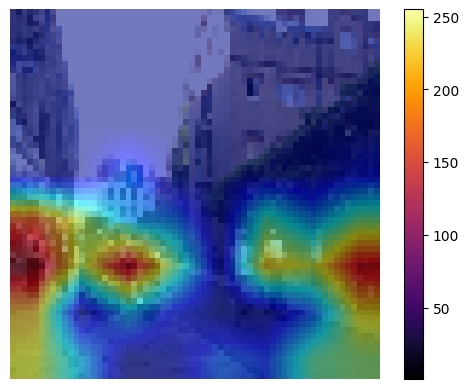

In [82]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from PIL import Image


class SemanticSegmentationTarget:
    def __init__(self, category, mask):
        self.category = category
        self.mask = torch.from_numpy(mask)
        if torch.cuda.is_available():
            self.mask = self.mask.cuda()

    def __call__(self, model_output):
        # output =
        return (model_output[self.category, :, : ] * self.mask).sum()

car_category = 3
# test = F.interpolate(torch.tensor(test).unsqueeze(0), scale_factor=4, mode='nearest')[0].numpy()
# test_downsampled = F.interpolate(torch.tensor(test).unsqueeze(0), scale_factor=0.25, mode='nearest')[0].numpy()

car_mask_float = np.float32(test == car_category)
input_tensor = image0[None, :].to(device)
# target_layers = [model.model.backbone.layer4]
target_layers = [model.decoder.mlp_layers[3][0]]
targets = [SemanticSegmentationTarget(car_category, car_mask_float)]

image0_downsampled = F.interpolate(torch.tensor(image0).unsqueeze(0), scale_factor=0.25, mode='nearest')[0]
image0_downsampled = image0_downsampled.permute(1, 2, 0).numpy()

image0_downsampled = image0_downsampled - np.min(image0_downsampled)
image0_downsampled = image0_downsampled / np.max(image0_downsampled)

with GradCAM(model=model,
             target_layers=target_layers,
             use_cuda=torch.cuda.is_available()) as cam:
    grayscale_cam = cam(input_tensor=input_tensor,
                        targets=targets)[0, :]
    print(grayscale_cam.shape)
    grayscale_cam = F.interpolate(torch.tensor(grayscale_cam).unsqueeze(0).unsqueeze(0), scale_factor=0.25, mode='nearest')[0][0].numpy()
    print(grayscale_cam.shape)
    print(test.shape)
    cam_image = show_cam_on_image(image0_downsampled, grayscale_cam, use_rgb=True)

# Image.fromarray(cam_image)
img = plt.imshow(cam_image, cmap='inferno')
plt.colorbar(img)
plt.axis('off')
plt.show()

In [18]:
image0.shape

torch.Size([3, 256, 256])

In [32]:
test.shape

(64, 64)

In [34]:
grayscale_cam.shape

(256, 64)

In [22]:
import torch.nn.functional as F

In [64]:
np.min(grayscale_cam)

0.0

In [39]:
image0.shape

torch.Size([3, 256, 256])

In [46]:
np.min(image0_downsampled)

-2.0640714

In [47]:

image0_downsampled = image0_downsampled - np.min(image0_downsampled)
image0_downsampled = image0_downsampled / np.max(image0_downsampled)

In [51]:
np.min(image0_downsampled)

-2.0640714

In [52]:
np.max(image0_downsampled)

2.64

In [67]:
np.max(car_mask_float)

0.0